# Brief - Les modèles dans tous leurs états

### Tutoriel 2 - Le dataset California Housing & la régression linéaire

Dans ce deuxième tutoriel, nous allons aborder un cas de régression linéaire. A travers un dataset fourni "california housing", il nous faut estimer le prix d'un bien à partir des paramètres d'entrée. 

In [ ]:
# régression linéaire, c'est supervisé
# les fleurs, c'est le seul pas supervisé, en k means
#sklearn.svm import SV
#ce n'est pas un random forest

Là encore, mettons en place notre environnement de travail avec les librairies adéquates.

In [61]:
# Import package
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import sklearn
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

###### Analyse du dataset

On importe notre dataset et on regarde sa description.

In [35]:
california_housing = fetch_california_housing(as_frame=True)

In [36]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Voici à quoi correspondent les attributs :
- MedInc : le revenu médian dans le groupe
- HouseAge : âge médian de la maison dans le groupe d'îlots
- AveRooms : nbre moyen de pièces par ménage
- AveBdrms : nbre moyen de chambres par ménage
- AveOccup : nbre de personnes dans le ménage

Par souci de lisibilité, on peut aussi afficher le dataset sous forme d'un dataframe

In [42]:
california_housing = california_housing.frame
california_housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [38]:
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [39]:
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Ici, nous avons plusieurs variables et attributs à comparer et qui peuvent rentrer en compte lors de l'estimation du bien. Afin de mesurer tous ces paramètres, nous allons faire une carte de chaleur (ou heatmap) et voir une corrélation ou non (ce qui sera plus rapide que les nuages de points, qui permettent de faire un parallèle entre deux valeurs).

<AxesSubplot:>

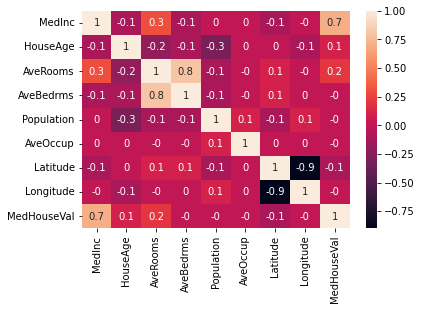

In [43]:
# Etude de la corrélation
matrice_corr = california_housing.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

A partir de cette heatmap, nous voyons des corrélations apparaître plus simplement. Nous aurons de notre valeur de référence, ici "MedHouseVal" (qui ce pour quoi nous cherchons à faire une régression linéaire).
La valeur d'un bien a une forte corrélation avec le revenu moyen d'un ménage et une corrélation plus modérée avec le nombres de pièces. Egalement, relevons la valeur Latitude, qui partage une corrélation des plus négatives.

Nous retiendrons donc comme paramètres "MedInc", "AveRooms" et "Latitude".

###### Mise en place du modèle d'apprentissage

On distingue bien les valeurs X et valeur Y

In [59]:
#on utilise seulement 3 variables explicatives
X=pd.DataFrame(
    np.c_[california_housing['MedInc'],
          california_housing['AveRooms'],
          california_housing['Latitude']], 
    columns = ['MedInc','AveRooms','Latitude']
)
Y = california_housing['MedHouseVal']

Comme pour le tutoriel précédent, et pour un apprentissage supervisé encore une fois, nous aurons besoin de faire deux groupes : les données d'apprentissage et les données de test, pour un ration 80% - 20%.

In [60]:
#base d'apprentissage et base de test
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(16512, 3)
(4128, 3)
(16512,)
(4128,)


In [49]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

LinearRegression()

###### Evaluation du modèle

In [50]:
# Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# model evaluation for testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.8264833577239211
le score R2 est 0.4822870285735622


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 0.8318060991418283
le score R2 est 0.4985073648213545


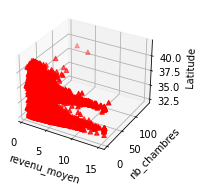

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(
    california_housing["MedInc"], 
    california_housing["AveRooms"], 
    california_housing["Latitude"], 
    c='r', marker='^')
 
ax.set_xlabel('revenu_moyen')
ax.set_ylabel('nb_chambres')
ax.set_zlabel('Latitude')
 
plt.show()

###### Effectuer des prédictions

In [62]:
def predict(x):
   return slope * x + intercept

In [63]:
#la variable fitLine sera un tableau de valeurs prédites depuis la tableau de variables X
fitLine = predict(X)
plt.plot(X, fitLine, c='r')

NameError: name 'slope' is not defined